# Import libraries

In [3]:
import os
import glob
import tqdm
import pickle

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
tf.random.set_seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# trimesh library enables processing triangular meshes and is a good choice to process off file formats
# off (Object File Format) stores data in the form of point coordinates, faces/surfaces 
# and their RGB values if any
!pip -q install trimesh
import trimesh

# Visualize unordered points data

In [1]:
# load the data directory
DATA_DIR = '/kaggle/input/modelnet10-princeton-3d-object-dataset/ModelNet10/'

In [2]:
import os

folders = os.listdir(DATA_DIR)

for folder in folders:
    train_path = os.path.join(DATA_DIR, folder, 'train')
    test_path = os.path.join(DATA_DIR, folder, 'test')

    # Count the number of files in the "train" directory
    num_train_files = len(os.listdir(train_path))

    # Count the number of files in the "test" directory
    num_test_files = len(os.listdir(test_path))

    print(f"Class: {folder}, Train Files: {num_train_files}, Test Files: {num_test_files}")


Class: sofa, Train Files: 680, Test Files: 100
Class: monitor, Train Files: 465, Test Files: 100
Class: desk, Train Files: 200, Test Files: 86
Class: bed, Train Files: 515, Test Files: 100
Class: bathtub, Train Files: 106, Test Files: 50
Class: night_stand, Train Files: 200, Test Files: 86
Class: chair, Train Files: 889, Test Files: 100
Class: toilet, Train Files: 344, Test Files: 100
Class: dresser, Train Files: 200, Test Files: 86
Class: table, Train Files: 392, Test Files: 100


In [10]:
# visualize the triangular mesh files
mesh1 = trimesh.load(os.path.join(DATA_DIR, 'toilet/train/toilet_0001.off'))
mesh1.show()

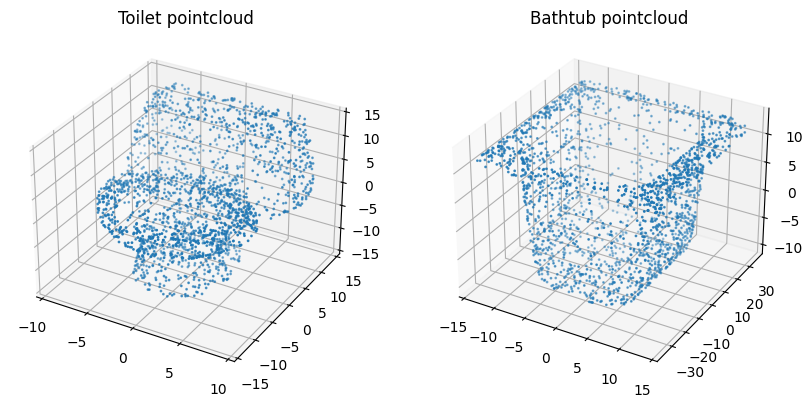

In [12]:
# sample some points (with uniform probability) from the mesh
mesh2 = trimesh.load(os.path.join(DATA_DIR, 'bathtub/train/bathtub_0010.off'))
points1 = mesh1.sample(2048)
points2 = mesh2.sample(2048)
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(points1[:, 0], points1[:, 1], points1[:, 2], s=1)
ax1.set_title('Toilet pointcloud')
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(points2[:, 0], points2[:, 1], points2[:, 2], s=1)
ax2.set_title('Bathtub pointcloud')
#ax.set_axis_off()
plt.show()

As observed here, points are randomly chosen from the mesh in an unordered fashion. This unordered data can be directly consumed by the PointNet architecture. There is no need to transform this data to regular 3D voxel grids or sequence of 2D images.

# Parse the ModelNet10 OFF (Object File Format) dataset

In [5]:
# Parse all the off files with 2048 randomly sampled points to generate a training and testing dataset
def parse_dataset(num_points=2048):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = os.listdir(DATA_DIR)
    
    for i, folder in tqdm.tqdm(enumerate(folders)):
        print('processing class: {}'.format(folder))
        #store folder name with id that can be retrieved later
        class_map[i] = folder
        train_files = glob.glob(os.path.join(DATA_DIR, folder, 'train/*'))
        test_files = glob.glob(os.path.join(DATA_DIR, folder, 'test/*'))
        
        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)
        
        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)
    
    return(
    np.array(train_points),
    np.array(train_labels),
    np.array(test_points),
    np.array(test_labels),
    class_map)

In [6]:
# declare model training parameters
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

In [9]:
# This section is a bit time consuming so I have saved the numpy files under parsed_data folder
# You can skip this cell and load the files directly in the next cell
train_points, train_labels, test_points, test_labels, class_map = parse_dataset(NUM_POINTS)

0it [00:00, ?it/s]

processing class: sofa


1it [01:42, 102.15s/it]

processing class: monitor


2it [02:05, 55.98s/it] 

processing class: desk


3it [02:26, 39.71s/it]

processing class: bed


4it [03:39, 52.98s/it]

processing class: bathtub


5it [03:53, 39.01s/it]

processing class: night_stand


6it [04:10, 31.36s/it]

processing class: chair


7it [06:19, 63.46s/it]

processing class: toilet


8it [07:16, 61.36s/it]

processing class: dresser


9it [07:49, 52.36s/it]

processing class: table


10it [08:24, 50.45s/it]


In [15]:
np.save('3d_train_points_MNet10.npy', train_points)
np.save('3d_train_labels_MNet10.npy', train_labels)
np.save('3d_test_points_MNet10.npy', test_points)
np.save('3d_test_labels_MNet10.npy', test_labels)

with open('class_map_dict.pkl', 'wb') as f:
    pickle.dump(class_map, f)

0it [00:00, ?it/s]

processing class: sofa


1it [01:28, 88.35s/it]

processing class: monitor


2it [01:46, 46.88s/it]

processing class: desk


3it [02:01, 32.51s/it]

processing class: bed


4it [03:00, 42.95s/it]

processing class: bathtub


5it [03:12, 31.61s/it]

processing class: night_stand


6it [03:25, 25.41s/it]

processing class: chair


7it [05:07, 50.50s/it]

processing class: toilet


8it [05:51, 48.27s/it]

processing class: dresser


9it [06:15, 40.86s/it]

processing class: table


10it [06:42, 40.20s/it]


In [3]:
PARSED_DIR = '/kaggle/working/'
train_points = np.load(PARSED_DIR + '3d_train_points_MNet10.npy')
train_labels = np.load(PARSED_DIR + '3d_train_labels_MNet10.npy')
test_points = np.load(PARSED_DIR + '3d_test_points_MNet10.npy')
test_labels = np.load(PARSED_DIR + '3d_test_labels_MNet10.npy')
with open(PARSED_DIR + 'class_map_dict.pkl', 'rb') as f:
    class_map = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/3d_train_points_MNet10.npy'

In [10]:
print(len(train_points))

3991


In [11]:
print(len(train_labels))

3991


In [12]:
print(len(test_points))

908


In [13]:
print(len(test_labels))

908


# Data augmentation through jitter and shuffle 

In [8]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label

# generate tensors from the data
train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [28]:
print(len(train_dataset))

125


In [29]:
print(test_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 2048, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


# Define PointNet architecture for classification

In [21]:
# Convolution -> BatchNormalization -> ReLU block
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding='valid')(x)
    # The decay rate is initialized as 0.5 and gradually increased to 0.99 in the paper
    # Somehow, decay rate of 0.0 works best here
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation('relu')(x)

# Dense -> BatchNormalization -> ReLU block
def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation('relu')(x)

In [22]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        # this step performs orthogonal transformation followed by Frobenius norm
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [23]:
def tnet(inputs, num_features):
    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 64)
    x = conv_bn(x, 128)
    x = conv_bn(x, 1024)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 512)
    x = dense_bn(x, 256)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="Identity",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    # Reshape feature transform
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

Define PointNet architecture for classification (as referenced in the paper)

In [24]:
inputs = keras.Input(shape=(NUM_POINTS, 3))
# T-net 1 with 3x3 output matrix
x = tnet(inputs, 3)
x = conv_bn(x, 64)
x = conv_bn(x, 64)
# T-net 2 with 64x64 output matrix
x = tnet(x, 64)
x = conv_bn(x, 64)
x = conv_bn(x, 128)
x = conv_bn(x, 1024)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 512)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 64)     256         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 64)    256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 64)     0           ['batch_normalization[0][0

# Train the model

In [30]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
125/125 [==============================] - 35s 174ms/step - loss: 3.1318 - sparse_categorical_accuracy: 0.6951 - val_loss: 1984762740736.0000 - val_sparse_categorical_accuracy: 0.7280
Epoch 2/20
125/125 [==============================] - 21s 169ms/step - loss: 3.1508 - sparse_categorical_accuracy: 0.6896 - val_loss: 260016538347072651264.0000 - val_sparse_categorical_accuracy: 0.5903
Epoch 3/20
125/125 [==============================] - 21s 169ms/step - loss: 2.9511 - sparse_categorical_accuracy: 0.7342 - val_loss: 184174262146301952.0000 - val_sparse_categorical_accuracy: 0.7126
Epoch 4/20
125/125 [==============================] - 21s 169ms/step - loss: 2.8307 - sparse_categorical_accuracy: 0.7597 - val_loss: 31739176.0000 - val_sparse_categorical_accuracy: 0.7126
Epoch 5/20
125/125 [==============================] - 21s 169ms/step - loss: 3.1914 - sparse_categorical_accuracy: 0.7337 - val_loss: 2282649471132735897600.0000 - val_sparse_categorical_accuracy: 0.2621
Epoch 6/

# Plot learning curves

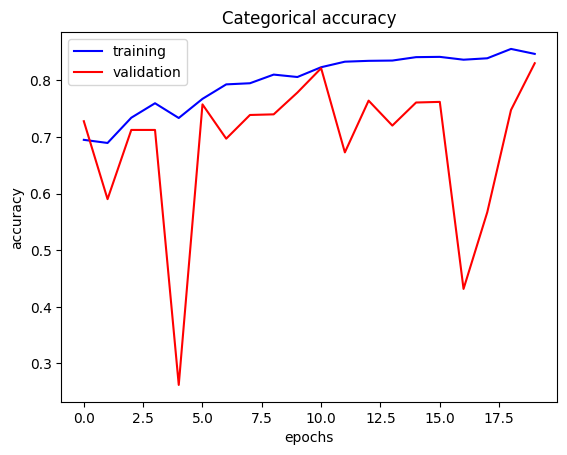

In [31]:
train_accuracy = model.history.history['sparse_categorical_accuracy']
val_accuracy = model.history.history['val_sparse_categorical_accuracy']
fig = plt.figure()
plt.plot(train_accuracy, color='blue', label='training')
plt.plot(val_accuracy, color='red', label='validation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Categorical accuracy')
plt.legend(loc='best')
plt.show()

# Confusion matrix on validation data

In [32]:
# load best model weights
model.load_weights('/kaggle/input/point-weights-v2/pointnet_weights_v2.hdf5')
preds = model.predict(test_dataset)
preds = tf.math.argmax(preds, -1)
print('Validation accuracy: {}'.format(np.mean(test_labels == preds)))

29/29 [==============================] - 2s 34ms/step
Validation accuracy: 0.9074889867841409


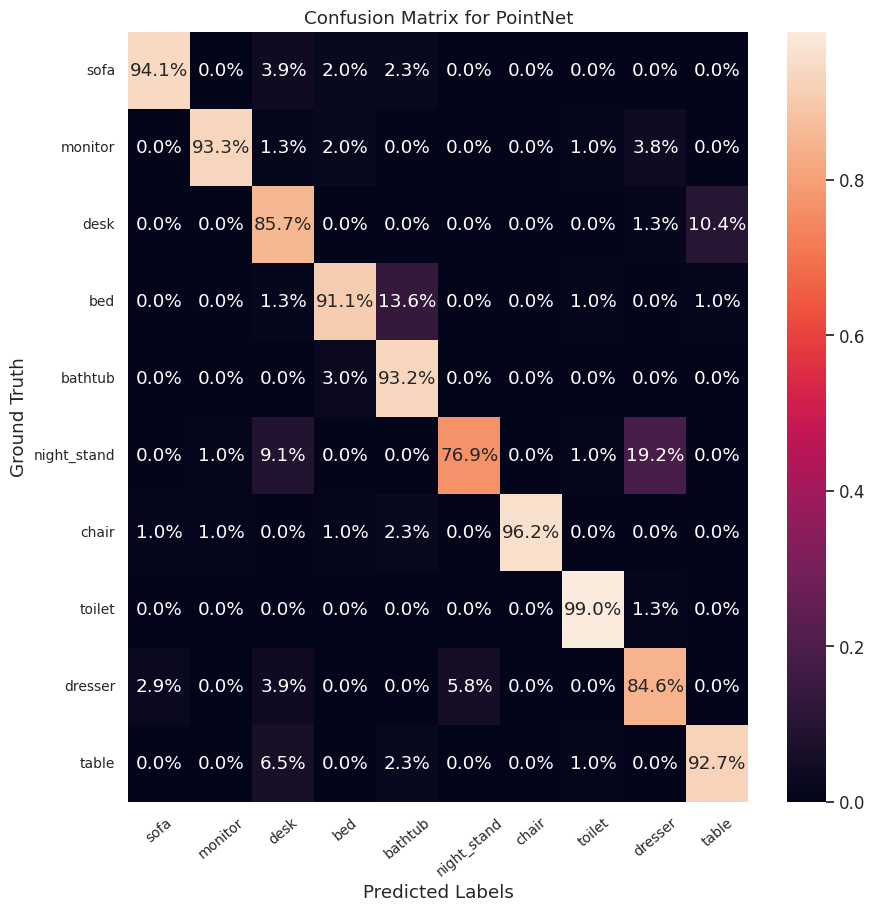

In [33]:
# confusion matrix
conf_matrix = confusion_matrix(preds, test_labels)
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.1)
ax = sns.heatmap(conf_matrix/np.sum(conf_matrix, axis=1), annot=True, fmt='.1%')
ax.set_xlabel('Predicted Labels')
ax.xaxis.set_ticklabels(list(class_map.values()), fontsize=10, rotation=40)
ax.yaxis.set_ticklabels(list(class_map.values()), fontsize=10, rotation=0)
ax.set_ylabel('Ground Truth')
ax.set_title('Confusion Matrix for PointNet')
plt.show()

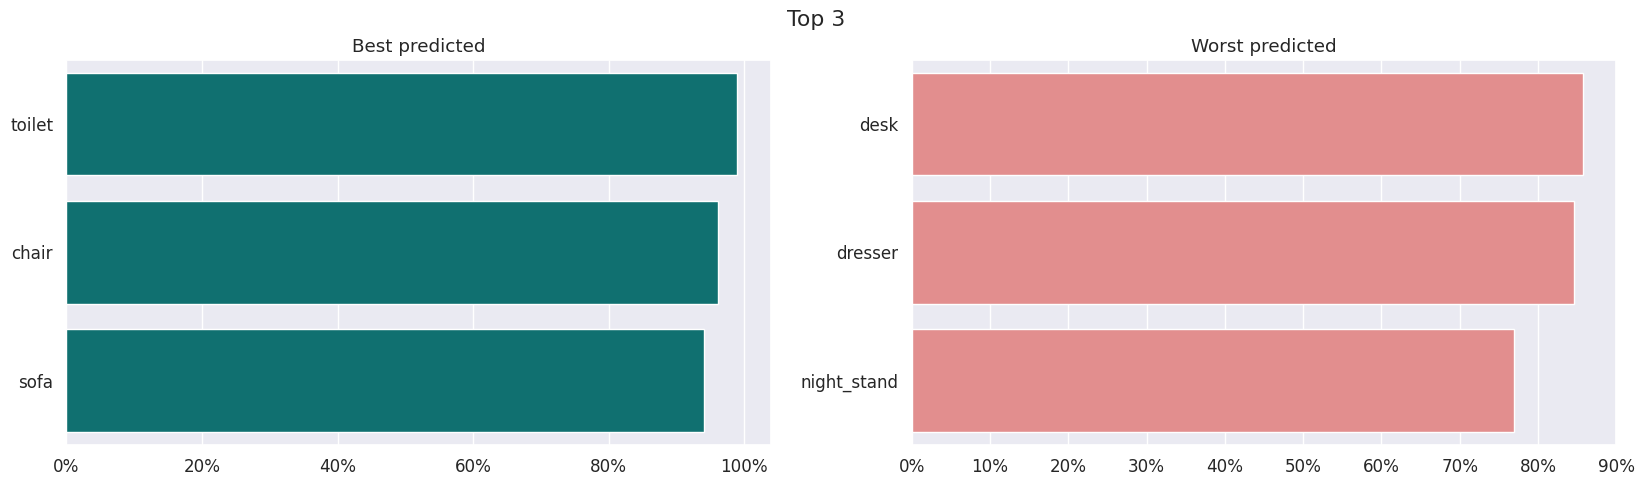

In [34]:
percent_mat = conf_matrix/np.sum(conf_matrix, axis=1)
percent_sort = np.sort(percent_mat)[:,-1]

# top 3 best and worst predicted classes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
best_3 = np.argpartition(percent_sort, -3)[-3:]
#descending sort
best_3 = np.flip(best_3[np.argsort(percent_sort[best_3])])
best_labels = [class_map[val] for val in best_3]

worst_3 = np.argpartition(percent_sort, 3)[:3]
#descending sort
worst_3 = np.flip(worst_3[np.argsort(percent_sort[worst_3])])
worst_labels = [class_map[val] for val in worst_3]

plt.subplot(1, 2, 1)
plt.title('Best predicted')
sns.barplot(y=best_labels, x=percent_sort[best_3]*100, orient='h', color='teal')
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter())

plt.subplot(1, 2, 2)
plt.title('Worst predicted')
sns.barplot(y=worst_labels, x=percent_sort[worst_3]*100, orient='h', color='lightcoral')
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter())
plt.suptitle('Top 3')
plt.show()

# Model predictions and visualizations

1/1 [==============================] - 1s 560ms/step


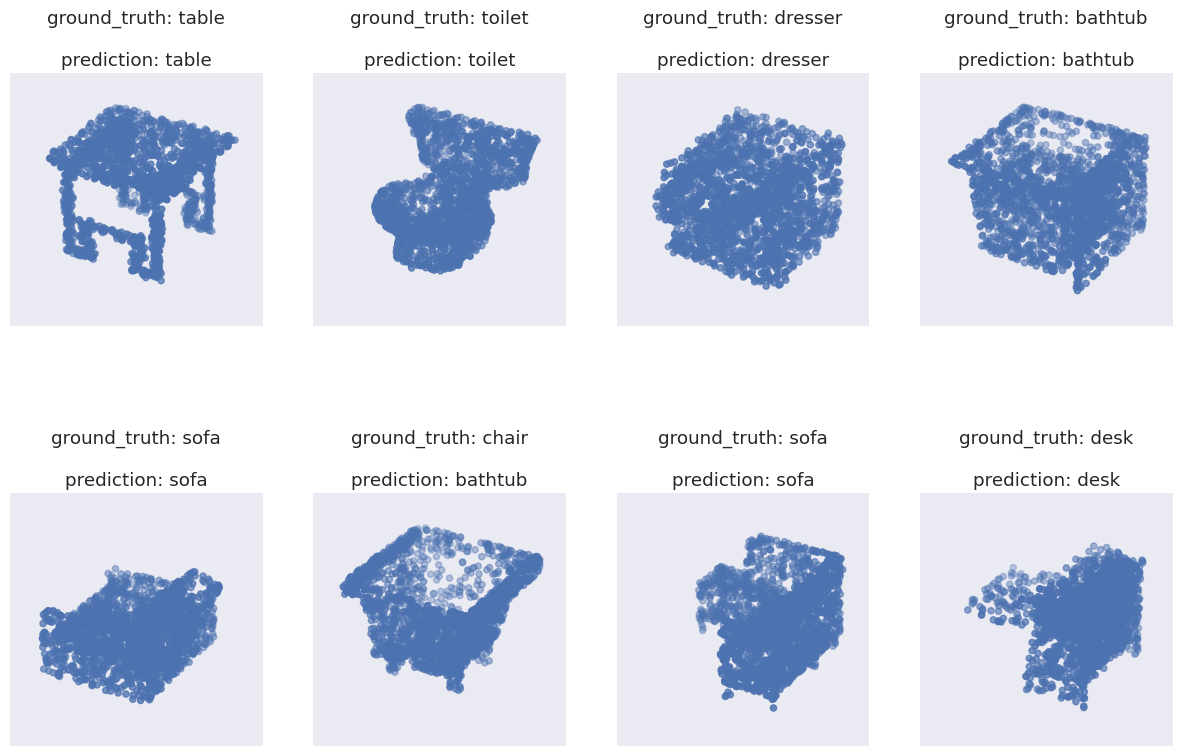

In [35]:
#shuffle test data
test_sample = tf.data.Dataset.from_tensor_slices((test_points, test_labels))
test_sample = test_sample.shuffle(len(test_points)).batch(BATCH_SIZE)
# plotting model predictions
data = test_sample.take(8)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "ground_truth: {:}\n\nprediction: {:}".format(
            class_map[preds[i].numpy()], class_map[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()